# **Exploring Topic Clusters in the #NBA Twittersphere**

# **Unsupervised Machine Learning Models - Clustering**

The purpose of fitting clustering models (a class of unsupervised machine learning models) to the dataset of tweets is to see if there are any well-defined clusters based on the words in the tweets.  These clusters can be thought of as topics.  In carrying out LDA topic modelling in the previous section, we saw that there are some well-defined topics in our dataset.  We will now try to corroborate this by building clustering models on the same data.  We will look at two different clustering models: **k-means clustering** and **DBSCAN (density-based spatial clustering of applications with noise)**.  Ultimately, we are looking for topics that are found by all three of LDA topic modelling, k-means clustering, and DBSCAN.

In [1]:
# the data science trifecta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for timing model fitting iterations inside of loops
from time import time

# for creating word clouds
import pickle # load final list of stopwords from preprocessing steps
from wordcloud import WordCloud

# unsupervised machine learning models - k-means clustering & DBSCAN
from sklearn.cluster import KMeans, DBSCAN

# silhouette score for evaluating clustering models
from sklearn.metrics import silhouette_score

%matplotlib inline

We will need the 3 forms of the dataset we have created: the cleaned master data, the vectorized tweet data, and the scaled vectorized tweet data.

In [2]:
# clean data
df = pd.read_csv('data/master_clean.csv')
display(df.head())
df.shape

,created_at,followers_count,friends_count,handle,hashtags,retweet,symbols,tweet,tweet_id,user_mentions,created_at_date,created_at_hour,created_at_dayofweek,created_at_dayofyear
0,2020-03-10 09:00:01-05:00,9672,664,RotoCurve,"[{'text': 'NBA', 'indices': [19, 23]}]",0,[],"The ""In The Paint"" #NBA Podcast returns with @...",1237377674298814464,"[{'screen_name': 'APfeifer24', 'name': 'Adam P...",2020-03-10,9,1,70
1,2020-03-10 09:00:11-05:00,71775,70998,RainmanPicks,"[{'text': 'NBA', 'indices': [115, 119]}]",0,[],Won't find anyone more consistent than us!\n\n...,1237377717756211200,[],2020-03-10,9,1,70
2,2020-03-10 09:00:28-05:00,3955,180,SimWorld4K,"[{'text': 'SeeTheGameBeTheGame', 'indices': [5...",0,[],More NBA news &amp; action! 👇 https://t.co/hhN...,1237377788535083008,[],2020-03-10,9,1,70
3,2020-03-10 09:00:29-05:00,2656,1509,bettheprop,[],1,[],1.5u - Russell Westbrook o45.5 pts+rbs+asts -1...,1237377792867815424,"[{'screen_name': 'PropBetGuy', 'name': 'Prop B...",2020-03-10,9,1,70
4,2020-03-10 09:00:32-05:00,157,332,WattersonDad,"[{'text': 'NBA', 'indices': [120, 124]}]",1,[],Ernie Johnson &amp; Chris Webber trying to exp...,1237377801944260608,"[{'screen_name': 'TodayInSports3', 'name': '#T...",2020-03-10,9,1,70


(15410, 14)

In [3]:
# vectorized clean data
X = pd.read_csv('data/X.csv')
display(X.head())
X.shape

,#,#1,#2020,#2k,#2k20,#2kcommunity,#76ers,#ad,#adamsilver,#adidas,...,😢,😭,😳,😷,🙌,🙏,🚨,🤔,🤣,🦠
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(15410, 1713)

In [4]:
# vectorized and scaled clean data
X_s = pd.read_csv('data/X_s.csv')
display(X_s.head())
X_s.shape

,#,#1,#2020,#2k,#2k20,#2kcommunity,#76ers,#ad,#adamsilver,#adidas,...,😢,😭,😳,😷,🙌,🙏,🚨,🤔,🤣,🦠
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(15410, 1713)

---

## **K-Means Clustering**

K-means clustering models try to find the best "centres" of the specified $k$ number of clusters.  These centres are found by calculating "distance" metrics between the centres and the surrounding points in a speculated cluster.

Like LDA topic modelling, the issue with k-means clustering is that it requires the number of clusters `n_clusters` ($k$) to be set before model fitting.  Ideally, we would make some sort of educated initial guess as to how many clusters there might be in our dataset (e.g. from our t-SNE analysis and/or PCA).  However, I prefer to first examine two clustering metrics against a range of $k$ values: the inertia (how tightly-grouped the points in a cluster are) and the silhouette score (how separate the clusters are).

Per the [scikit-learn documentation for the silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html),

    The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar

In [5]:
%%time

n_clusters = [5, 10, 25, 50] # k values to loop through

# summary message
print(f'Fitting {n_clusters}-means clustering models on a dataset of {X_s.shape[0]} rows and {X_s.shape[1]} features.\n')  

inertias = list() # empty list to append inertia values to
km_silhouette_scores = list() # empty list to append silhouette scores to

for k in n_clusters:
    fit_start_time = time()
    
    # model instantiation and fitting
    km = KMeans(
        n_clusters = k,
        random_state = 1,
        n_jobs = -1
    )
    km.fit(X_s) # fit the model to the scaled vectorized text data
    
    # individual model fitting timer
    print(f'{k}-means clustering model successfully fit in {time() - fit_start_time:0.1f} seconds.')
    
    # append inertia to running list
    inertias.append(km.inertia_)
    
    # append silhouette score to running list
    km_silhouette_scores.append(silhouette_score(X_s, km.labels_, random_state=1))

print()

Fitting [5, 10, 25, 50]-means clustering models on a dataset of 15410 rows and 1713 features.

5-means clustering model successfully fit in 14.3 seconds.
10-means clustering model successfully fit in 16.6 seconds.
25-means clustering model successfully fit in 32.0 seconds.
50-means clustering model successfully fit in 56.5 seconds.

Wall time: 2min 32s


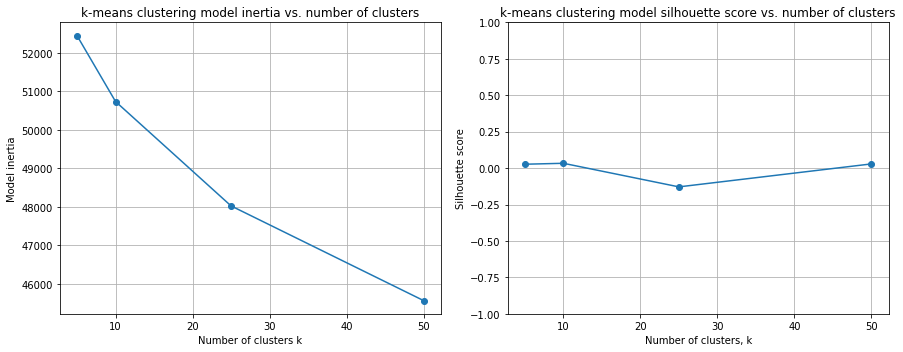

In [6]:
plt.subplots(1, 2, figsize=(13,5))

plt.subplot(1, 2, 1)
plt.plot(n_clusters, inertias, marker='o')
plt.title('k-means clustering model inertia vs. number of clusters')
plt.xlabel('Number of clusters k')
plt.ylabel('Model inertia')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(n_clusters, km_silhouette_scores, marker='o')
plt.title('k-means clustering model silhouette score vs. number of clusters')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette score')
plt.ylim(-1, 1)
plt.grid()

plt.tight_layout()
plt.show()

Here we note that there is no drastic drop in inertia ("elbow") for any of the number of clusters we tested, which tells us that no value of $k$ creates tightly-grouped clusters.  However, we saw in our t-SNE and LDA topic modelling analyses there indeed was some sort of cluster structure in our dataset - 40 and 16 clusters, respectively.  Because we observe a continuous, seemingly exponential decrease in the inertia as $k$ increases, we would imagine that we can reduce the k-means clustering inertia even further by increasing the number of clusters, but too many clusters could make our end results more granular and difficult to interpret.  We can essentially ignore the inertia as an evaluation metric at this point, as there is no reasonable way to find the trade-off between low inertia and model/cluster interpretability.

In terms of the silhouette scores, it seems that our data naturally has overlapping clusters - for a broad range of $k$ values, the silhouette score hovers close 0.  We are thus left to pick the value of $k$ that yields the highest silhouette score - that value happens to be 10.

### First Iteration ($k = 10$)

In [7]:
%%time

n_clusters = 10

# instantiate model and fit using scaled vectorized text data
km = KMeans(
    n_clusters = n_clusters,
    random_state = 1,
    n_jobs = -1
)
km.fit(X_s) # fit 

Wall time: 15.2 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [8]:
# number of tweets in each cluster
km_cluster_sizes = pd.Series(km.labels_).value_counts()
km_cluster_sizes

6    12719
3     1218
0      580
1      425
5      172
4      109
9       58
8       51
7       45
2       33
dtype: int64

Now let's try to interpret each cluster.  I will attach the cluster labels to the unscaled vectorized dataset, then manually examine the averages of the word counts in each cluster.  If the mean word counts are close to 1, then that means that word is present in nearly every tweet in that cluster.

In [9]:
X_km_cluster = X.copy() # copy the dataset
X_km_cluster['cluster'] = pd.Series(km.labels_) # add the cluster labels from the model to each tweet

# create a dataframe grouped by the cluster label and calculate the means of each word's counts
X_km_cluster_mwc = X_km_cluster.groupby('cluster').mean()

In [10]:
km_cluster_num = 3 # choose one of the cluster labels from this model
assert km_cluster_num in km_cluster_sizes.index, 'km_cluster_num must be one of the cluster labels'
thresh = 0.1 # threshold of mean word count

# indices of the tweets that are in the chosen cluster
cluster_tweet_indices = X_km_cluster[X_km_cluster['cluster'] == km_cluster_num].index

# mean word counts (scaled) of the tweets in the chosen cluster
# only show words that have mean counts that are greater than the specified threshold
km_cluster_mwc = X_km_cluster_mwc.iloc[km_cluster_num]
print(f'Cluster label {km_cluster_num}: {km_cluster_sizes[km_cluster_num]} tweets')
display(km_cluster_mwc[km_cluster_mwc > thresh].sort_values(ascending=False))

Cluster label 3: 1218 tweets


test                    0.615764
positive                0.546798
gobert                  0.449097
player                  0.433498
rudy                    0.424466
#coronavirus            0.420361
coronavirus             0.309524
season                  0.297209
suspend                 0.293924
jazz                    0.264368
#covid19                0.211002
utah                    0.210181
mitchell                0.148604
donovan                 0.134647
#rudygobert             0.120690
#coronaviruspandemic    0.117406
get                     0.111658
#jazz                   0.111658
Name: 3, dtype: float64

In [11]:
# random sample of tweet/retweet in the chosen cluster, and who tweeted/retweeted it
print(f'Cluster {km_cluster_num}\n')
print(f'Tweet from @{df["handle"][pd.Series(cluster_tweet_indices).sample().values[0]]}\n')
print(df['tweet'][pd.Series(cluster_tweet_indices).sample().values[0]])

Cluster 3

Tweet from @ColeCross57

This how I'm pulling up on Rudy Gobert to whoop his ass if I'm his teammate #COVD19 #CoronaOutbreak #CoronavirusPandemic  #NBATwitter #NBA #rudygobert https://t.co/hkHrQTjYdA


10-means clustering interpretations, in order of descending cluster size:

1. **Cluster label 6** - The largest cluster.  A good amount of these tweets mention coronavirus and sports leagues other than the NBA, but there are other tweets in this cluster about many other topics (sports betting/gambling, Trump, NBA game updates, basketball shoes, etc.) which could be considered as "noise"
2. **3** - Rudy Gobert testing positive for the coronavirus disease
3. **0** - Most of these include "#sports", and some are about sports betting, but there is no strong topic outside of that
4. **1** - Tweets with "#nbasuspended"
5. **5** - Tweets using the San Antonio Spurs team hashtag "#GoSpursGo".  The Spurs played the Dallas Mavericks on March 10
6. **4** - Tweets from (and retweets of) @SportsWatch1, all about sports betting picks.  The same hashtags are used in every tweet, which helps to "define" this cluster
7. **9** - Tweets from @Homerunbot1, most are news articles from major news outlets about coronavirus.  The same hashtags are used in every tweet
8. **8** - Tweets using the Orlando Magic team hashtag "#MagicAboveAll".  The Magic played the Memphis Grizzlies on March 10
9. **7** - Tweets about Giannis Antetokounmpo
10. **2** - Retweets of mostly Los Angeles Lakers tweets and some Cleveland Cavaliers tweets, all by the @LionelPeyronnet account

Maybe the most interesting aspect of this model is that it did not pick up strongly on a cluster(s) about sports betting or daily fantasy sports (DFS) (that aren't all from one account).  These tweets are spread throughout clusters 6, 0, and 4, possibly explaining the overlap that was indicate by the silhouette scores.  If this is indeed the case, then sports betting/DFS tweets could be considered "noise" in our dataset.

Note that when many of the mean word counts of a cluster are close to 1, it is indicative that the same words are used in all of the tweets in the cluster.  Bot-like accounts will do this, because they often append the same set of hashtags at the end of all of their tweets.  This is the case for clusters 4, 9, and 2.

I want to try "opening up" the `n_clusters` parameter to see if k-means clustering can pick up on a more well-defined sports betting cluster.  Let's try `n_clusters = 12`.

### Second Iteration ($k = 12$)

In [12]:
%%time

n_clusters = 12

# instantiate model and fit using scaled vectorized text data
km = KMeans(
    n_clusters = n_clusters,
    random_state = 1,
    n_jobs = -1
)
km.fit(X_s)

Wall time: 17.6 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [13]:
# number of tweets in each cluster
km_cluster_sizes = pd.Series(km.labels_).value_counts()
km_cluster_sizes

6     12528
3      1279
0       580
1       420
5       169
10      111
4       109
9        58
8        49
7        45
2        33
11       29
dtype: int64

In [14]:
X_km_cluster = X.copy() # copy the dataset
X_km_cluster['cluster'] = pd.Series(km.labels_) # add the cluster labels from the model to each tweet

# create a dataframe grouped by the cluster label and calculate the means of each word's counts
X_km_cluster_mwc = X_km_cluster.groupby('cluster').mean()

In [15]:
km_cluster_num = 10 # choose one of the cluster labels from this model
assert km_cluster_num in km_cluster_sizes.index, 'km_cluster_num must be one of the cluster labels'
thresh = 0.1 # threshold of mean word count

# indices of the tweets that are in the chosen cluster
cluster_tweet_indices = X_km_cluster[X_km_cluster['cluster'] == km_cluster_num].index

# mean word counts (scaled) of the tweets in the chosen cluster
# only show words that have mean counts that are greater than the specified threshold
km_cluster_mwc = X_km_cluster_mwc.iloc[km_cluster_num]
print(f'Cluster label {km_cluster_num}: {km_cluster_sizes[km_cluster_num]} tweets')
display(km_cluster_mwc[km_cluster_mwc > thresh].sort_values(ascending=False))

Cluster label 10: 111 tweets


#takenote               1.000000
rudy                    0.378378
gobert                  0.369369
#coronavirus            0.252252
jazz                    0.252252
coronavirus             0.225225
v                       0.216216
utah                    0.207207
#jazz                   0.180180
mitchell                0.171171
positive                0.171171
test                    0.171171
#utahjazz               0.162162
donovan                 0.153153
#rudygobert             0.135135
player                  0.126126
#utah                   0.126126
#thunderup              0.117117
game                    0.117117
season                  0.108108
#coronaviruspandemic    0.108108
Name: 10, dtype: float64

In [16]:
# random sample of tweet/retweet in the chosen cluster, and who tweeted/retweeted it
print(f'Cluster {km_cluster_num}\n')
print(f'Tweet from @{df["handle"][pd.Series(cluster_tweet_indices).sample().values[0]]}\n')
print(df['tweet'][pd.Series(cluster_tweet_indices).sample().values[0]])

Cluster 10

Tweet from @StarSeedKid

#NBA: Rudy Gobert apologizes for 'embarrassing, inexcusable' virus gaffe #TakeNote #COVID19 

https://t.co/sUdV5lr9WK


All of the 10-means clusters and their labels appear in the 12-means clustering model, but here are the interpretations of the 2 additional clusters:

- **10** - Tweets using the Utah Jazz team hashtag "#TakeNote".  Much of this is about Rudy Gobert, Emmanuel Mudiay, and Donovan Mitchell (the Utah Jazz players who contracted the coronavirus), so we can see that this cluster somewhat overlaps with cluster 3
- **11** - Sports betting picks/predictions mostly from @SportsChatPlace and @PickDawgz

### Third Iteration ($k = 14$)

I will not include the code for this iteration as it is exactly the same the first two iterations, just with `n_clusters = 14`.

Same clusters as the 12-means clustering model.  The additional 2 clusters are:

- **12** - Mostly from @socialstartnow.  Hashtags for many major news outlets are appended to every tweet
- **13** - A 5-tweet cluster about the announcement of the Pelicans-Kings game on March 11 being postponed

### Fourth (Final) Iteration ($k = 16$)

In [17]:
%%time

n_clusters = 16

# instantiate model and fit using scaled vectorized text data
km = KMeans(
    n_clusters = n_clusters,
    random_state = 1,
    n_jobs = -1
)
km.fit(X_s) # fit 

Wall time: 23.7 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [18]:
# number of tweets in each cluster
km_cluster_sizes = pd.Series(km.labels_).value_counts()
km_cluster_sizes

6     12526
3      1146
0       496
1       419
5       167
14      156
10      111
4       109
9        58
8        47
7        45
12       40
2        33
11       29
15       23
13        5
dtype: int64

In [19]:
X_km_cluster = X.copy() # copy the dataset
X_km_cluster['cluster'] = pd.Series(km.labels_) # add the cluster labels from the model to each tweet

# create a dataframe grouped by the cluster label and calculate the means of each word's counts
X_km_cluster_mwc = X_km_cluster.groupby('cluster').mean()

In [20]:
km_cluster_num = 14 # choose one of the cluster labels from this model
assert km_cluster_num in km_cluster_sizes.index, 'km_cluster_num must be one of the cluster labels'
thresh = 0.1 # threshold of mean word count

# indices of the tweets that are in the chosen cluster
cluster_tweet_indices = X_km_cluster[X_km_cluster['cluster'] == km_cluster_num].index

# mean word counts (scaled) of the tweets in the chosen cluster
# only show words that have mean counts that are greater than the specified threshold
km_cluster_mwc = X_km_cluster_mwc.iloc[km_cluster_num]
print(f'Cluster label {km_cluster_num}: {km_cluster_sizes[km_cluster_num]} tweets')
display(km_cluster_mwc[km_cluster_mwc > thresh].sort_values(ascending=False))

Cluster label 14: 156 tweets


#betting            0.871795
#sportsbetting      0.711538
#gambling           0.628205
bet                 0.544872
#nfl                0.487179
#soccer             0.480769
#tips               0.461538
#football           0.455128
#mlb                0.442308
#money              0.397436
pick                0.378205
#tipster            0.365385
#sport              0.352564
#bettingtips        0.346154
#sports             0.333333
#bet                0.314103
#nhl                0.288462
#bettingexpert      0.288462
last                0.262821
#bets               0.256410
#gamblingtwitter    0.243590
#win                0.243590
minute              0.243590
today               0.217949
winner              0.217949
#vegas              0.185897
#casino             0.173077
acca                0.153846
#sportsbook         0.153846
#cbb                0.153846
#free               0.147436
#picks              0.134615
text                0.128205
#bovada             0.121795
u             

In [21]:
# random sample of tweet/retweet in the chosen cluster, and who tweeted/retweeted it
print(f'Cluster {km_cluster_num}\n')
print(f'Tweet from @{df["handle"][pd.Series(cluster_tweet_indices).sample().values[0]]}\n')
print(df['tweet'][pd.Series(cluster_tweet_indices).sample().values[0]])

Cluster 14

Tweet from @Parleys_Doki

NBA Contrarian Play
🏀DET +12
#GamblingTwitter #SportsBetting #FreePicks #NBA                  #NBAPicks #NBATwitter                  #bettingadvice #sportscapping #betting #gambling


Same clusters as the 14-means clustering model.  The additional 2 clusters are:

- **14** - **A very well-defined (top mean word counts are close to 1) cluster about sports betting across all major sports leagues, with tweets from multiple different accounts**!
- **15** - Tweets about NBA players who record double-doubles (registering at least 10 in two of the following categories: points, rebounds, assists, steals, blocks)

We see that it took at least $k = 16$ to identify a strong cluster about sports betting.  However, as noted earlier, these changes in $k$ don't improve the silhouette score of this k-means clustering model.

Our main takeaway here is that we have some decently-defined clusters in terms of their respective words, but overall, clusters found from k-means clustering exhibit overlap, as indicated by the silhouette score staying relatively constant around 0.

### Word Clouds of K-Means Top Clusters

In [22]:
# import stopwords from preprocessing steps
with open('stopwords.pickle', 'rb') as f:
    stopwords = pickle.load(f)

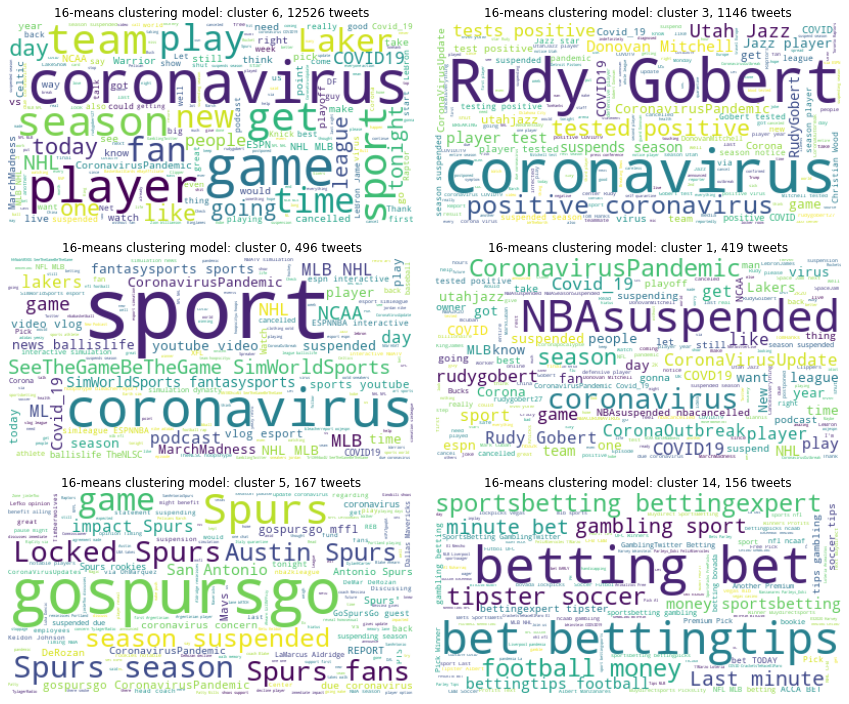

In [23]:
# top 6 clusters
km_top_cluster_nums = km_cluster_sizes.index[:6]

plt.subplots(3, 2, figsize=(12, 10))

for i in range(len(km_top_cluster_nums)):
    
    # get cluster number
    cluster = km_top_cluster_nums[i]

    # generate single string of all tweets in cluster
    df['km_cluster'] = km.labels_
    cluster_tweets = df['tweet'][df['km_cluster'] == cluster]
    cluster_tweets_str = ' '.join(tweet for tweet in cluster_tweets)

    # create word cloud
    wordcloud = WordCloud(
        stopwords = stopwords + ['https', 'co', 'nbatwitter'],
        background_color = 'white',
        random_state = 1
    ).generate(cluster_tweets_str)

    plt.subplot(3, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'16-means clustering model: cluster {cluster}, {km_cluster_sizes[cluster]} tweets')
    plt.axis('off')

plt.tight_layout()
plt.show()

As noted in the preprocessing steps of this project, the word clouds do not replicate exactly the lists of frequently-occurring words generated above due to the seemingly built-in punctuation handling by the `WordCloud()` function.  However, they still serve as decent ways to visualize the words in each cluster.

---

## **DBSCAN (Density-Based Spatial Clustering of Applications With Noise)**

We look to improve on our k-means clustering findings by using DBSCAN models.  DBSCAN searches for nearby data points based on a search radius `eps` and a check if `min_samples` data points are within that radius.  Naftali Harris has created an excellent visualization of the DBSCAN algorithm [here](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/).  One of the advantages of using DBSCAN is that it marks any "noise" points with a cluster label of -1.  A larger `eps` will increase the size (in feature space) of the clusters, and a higher `min_samples` will result in more dense clusters.  Let's first try `eps = 2` and `min_samples = 10`, then we will look to iteratively improve the model by checking the cluster interpretabilities at each iteration.  We will also see how the silhouette score changes at each iteraiton.

In [24]:
dbc_silhouette_scores = list()

### First Iteration: `eps = 2` & `min_samples = 10`

In [25]:
%%time

# THIS CELL TAKES A FEW MINUTES TO RUN!

# instantiate and fit DBSCAN model
# "dbc" for "density-based clustering"
dbc = DBSCAN(
    eps = 2,
    min_samples = 10,
    n_jobs = -1
).fit(X_s)

Wall time: 2min 54s


In [26]:
%%time

# check silhouette score of model
dbc_silhouette_score = silhouette_score(X_s, dbc.labels_, random_state=1)
dbc_silhouette_scores.append(dbc_silhouette_score)
dbc_silhouette_score

Wall time: 8.18 s


0.19444215177151106

This initial DBSCAN model yields an improvement in the silhouette score over the k-means clustering models we created!  The DBSCAN model has thus found some distinct cluster structure.

In [27]:
len(pd.Series(dbc.labels_).value_counts().index) - 1 # number of clusters

20

The model has found 20 clusters.

In [28]:
dbc_cluster_sizes = pd.Series(dbc.labels_).value_counts() # number of tweets in each cluster
dbc_cluster_sizes

 0     12279
-1      2627
 3       109
 6        54
 2        44
 12       37
 10       37
 8        24
 16       23
 9        22
 11       21
 4        20
 1        17
 15       16
 13       14
 18       13
 17       12
 19       11
 7        10
 5        10
 14       10
dtype: int64

We first notice that there are more clusters than we had in our k-means clustering model.  Another curious result is that cluster label 0 is over 4 times larger than the noisy data.  Also, most of the clusters are quite small.

In [29]:
X_dbc_cluster = X.copy() # attach the cluster labels to the X dataframe
X_dbc_cluster['cluster'] = pd.Series(dbc.labels_) # add a column of the model's cluster labels

# create a dataframe grouped by the cluster label and calculating the aggregate mean of each word's count
X_dbc_cluster_mwc = X_dbc_cluster.groupby('cluster').mean()

# need to reset index since we want to be able to access the noisy data ("cluster" number/index -1)
X_dbc_cluster_mwc.reset_index(inplace=True)

In [30]:
dbc_cluster_num = 11 # choose one of the cluster labels from this model
assert dbc_cluster_num in dbc_cluster_sizes.index, 'dbc_cluster_num must be one of the cluster labels'
thresh = 0.05 #threshold of mean word count

# indices of the tweets that are in the chosen cluster
cluster_tweet_indices = X_dbc_cluster[X_dbc_cluster['cluster'] == dbc_cluster_num].index

# mean word counts of the tweets in the chosen cluster
mwc = X_dbc_cluster_mwc[X_dbc_cluster_mwc['cluster'] == dbc_cluster_num].T[1:]
mwc.rename(columns={dbc_cluster_num+1:dbc_cluster_num}, inplace=True)
print(f'Cluster label {dbc_cluster_num}: {dbc_cluster_sizes[dbc_cluster_num]} tweets')
display(mwc[mwc[dbc_cluster_num] > thresh].sort_values(dbc_cluster_num, ascending=False))

Cluster label 11: 21 tweets


,11
#lockercodes,2.000000
#codes,1.000000
lockercode,1.000000
#myteam #myteam #pinkdiamond,1.000000
#nba2k20lockercodes,1.000000
#nba2k20 #nba2k20myteam,1.000000
#pg13,1.000000
want,1.000000
#vc,1.000000
#xbox #mt,1.000000


In [31]:
# random sample of tweet in the chosen cluster
print(f'Cluster {dbc_cluster_num}\n')
print(f'Tweet from @{df["handle"][pd.Series(cluster_tweet_indices).sample().values[0]]}\n')
print(df['tweet'][pd.Series(cluster_tweet_indices).sample().values[0]])

Cluster 11

Tweet from @lockerc72148549

If anyone wants a galaxy opal Andrei Kirilenko lockercode, then Dm me #Xbox #mt #vc #LockerCodes #Lockercodes #NBA2K20 #nba2k20myteam #codes ⁠⁠#nba        #Nba     #2k20   #kobe #giannis ⁠ ⁠⁠⁠ #ronnie2k  #myteam  #MyTeam  #pinkdiamond #pg13 #NBA2K20LOCKERCODES https://t.co/eKh5JrYOIk


Most of the noisy tweets (cluster label -1) are about games and seasons being suspended in the NHL and MLB due to coronavirus.  The clusters, in order of descending cluster size, are as follows:

1. **0** - Quite similar to the noise
2. **3** - Tweets from (and retweets of) @SportsWatch1, all about sports betting picks.  The same hashtags are used in every tweet
3. **6** - Tweets from @Homerunbot1, most are news articles from major news outlets about coronavirus.  The same hashtags are used in every tweet
4. **2** - Follow trains
5. **12** - Sports betting tips from @winnertipster1.  Interestingly, these are not NBA bets, but each tweet contains "#nba"
6. **10** - Seems like tweets that are automatically generated after using @Poshmarkapp, a fashion app
7. **8** - Tweets mostly from @socialstartnow1 containing "#nba".  News articles not related to the NBA
8. **16** - Retweets of mostly Los Angeles Lakers tweets and some Cleveland Cavaliers tweets, all by the @LionelPeyronnet account
9. **9** - Tweets from @FullPressRadio.  Each tweet has the same hashtags, "#nba" included
10. **11** - Tweets about locker codes in the NBA 2K20 video game

I could continue analyzing these clusters, but there seems to be one trend of note.  Because these clusters are quite granular (small), our model has correctly identified some of the clusters as being all tweets from a single user who usually includes the same words/hashtag in every tweet.  These kinds are what I would deem as bot-like.

Let's try to adjust the DBSCAN parameters that would yield less but larger clusters.

### Second Iteration: `eps = 2.4` & `min_samples = 10`

To avoid creating granular clusters, we can increase `eps`.  Let's try `eps = 2.4`, keeping `min_samples` the same as the first iteration.

In [32]:
%%time

# THIS CELL TAKES A FEW MINUTES TO RUN!

# instantiate and fit DBSCAN model
dbc = DBSCAN(
    eps = 2.4,
    min_samples = 10,
    n_jobs = -1
).fit(X_s)

Wall time: 3min 9s


In [33]:
%%time

# check silhouette score of model
dbc_silhouette_score = silhouette_score(X_s, dbc.labels_, random_state=1)
dbc_silhouette_scores.append(dbc_silhouette_score)
dbc_silhouette_score

Wall time: 8.57 s


0.22894886392732516

Note the slight improvement in the silhouette score over the first iteration.

In [34]:
len(pd.Series(dbc.labels_).value_counts().index) - 1 # number of clusters

13

Increasing `eps` from 2 to 2.4 has successfully forced the model to find 7 less clusters (from 20 down to 13).

In [35]:
dbc_cluster_sizes = pd.Series(dbc.labels_).value_counts() # number of tweets in each cluster
dbc_cluster_sizes

 0     14277
-1       750
 2       109
 4        54
 6        37
 8        37
 5        31
 7        24
 3        23
 1        17
 10       16
 12       13
 11       12
 9        10
dtype: int64

Similar to our first iteration, most of the clusters are still quite small.

In [36]:
X_dbc_cluster = X.copy() # attach the cluster labels to the X dataframe
X_dbc_cluster['cluster'] = pd.Series(dbc.labels_) # add a column of the model's cluster labels

# create a dataframe grouped by the cluster label and calculating the aggregate mean of each word's count
X_dbc_cluster_mwc = X_dbc_cluster.groupby('cluster').mean()

# need to reset index since we want to be able to access the noisy data ("cluster" number/index -1)
X_dbc_cluster_mwc.reset_index(inplace=True)

In [37]:
dbc_cluster_num = -1 # choose one of the cluster labels from this model
assert dbc_cluster_num in dbc_cluster_sizes.index, 'dbc_cluster_num must be one of the cluster labels'
thresh = 0.08 #threshold of mean word count

# indices of the tweets that are in the chosen cluster
cluster_tweet_indices = X_dbc_cluster[X_dbc_cluster['cluster'] == dbc_cluster_num].index

# mean word counts of the tweets in the chosen cluster
mwc = X_dbc_cluster_mwc[X_dbc_cluster_mwc['cluster'] == dbc_cluster_num].T[1:]
mwc.rename(columns={dbc_cluster_num+1:dbc_cluster_num}, inplace=True)
print(f'Cluster label {dbc_cluster_num}: {dbc_cluster_sizes[dbc_cluster_num]} tweets')
display(mwc[mwc[dbc_cluster_num] > thresh].sort_values(dbc_cluster_num, ascending=False))

Cluster label -1: 750 tweets


,-1
#mlb,0.177333
game,0.177333
#nhl,0.160000
season,0.152000
get,0.136000
player,0.130667
pick,0.128000
#nfl,0.125333
#sports,0.124000
v,0.121333


In [38]:
# random sample of tweet in the chosen cluster
print(f'Cluster {dbc_cluster_num}\n')
print(f'Tweet from @{df["handle"][pd.Series(cluster_tweet_indices).sample().values[0]]}\n')
print(df['tweet'][pd.Series(cluster_tweet_indices).sample().values[0]])

Cluster -1

Tweet from @StrangePeaches

Go to https://t.co/FkAfPZaUfC
Take your sign up bonus up to 5 BTC &amp; start betting by #bitcoin 

#btc #China #HongKong #crypto #cryptocurrency #bitcoin #bonus #bet #betting #soccer #basketball #tennis #nba #ucl #uel #uefa #epl #bundesliga #SerieA #League1 #live https://t.co/x0uMkkRN2U


Noise - General tweets about the MLB, NHL, and NFL, with mentions of coronavirus.  Sports betting tweets as well.

1. **0** - The NBA suspending their season due to coronavirus
2. **2** - Sports betting picks from @SportsWatch1
3. **4** - Tweets from @Homerunbot1
4. **6** - Tweets promoting @Poshmarkapp
5. **8** - Sports betting picks from @winnertipster1
6. **5** - Tweets mostly from @socialstartnow1 containing "#nba".  News articles not related to the NBA
7. **7** - Tweets about locker codes in the NBA 2K20 video game
8. **3** - Tweets from @SimWorld4K
9. **1** - Also tweets from @SimWorld4K, just with slightly different hashtags
10. **10** - Mostly tweets from @Buydirectsports.  Sports betting odds
11. **12** - Tweets from @Parleys_Doki.  These have no useful information in them
12. **11** - Tweets from @Quantum_Betting.  These seem to just be shared news articles that have a number of hashtags appended to them
13. **9** - Another cluster of tweets from @SimWorld4K

We observe similar results - DBSCAN picks up well on "clusters" that are all tweets from a single account that uses the same hashtags in every tweet.

Let's attempt one more iteration to obtain even larger clusters.

### Third (Final) Iteration: `eps = 2.6` & `min_samples = 10`

Let's increase `eps` to 2.6, while keeping `min_samples` the same.

In [39]:
%%time

# THIS CELL TAKES A FEW MINUTES TO RUN!

# instantiate and fit DBSCAN model
dbc = DBSCAN(
    eps = 2.6,
    min_samples = 10,
    n_jobs = -1
).fit(X_s)

Wall time: 3min 16s


In [40]:
%%time

# check silhouette score of model
dbc_silhouette_score = silhouette_score(X_s, dbc.labels_, random_state=1)
dbc_silhouette_scores.append(dbc_silhouette_score)
dbc_silhouette_score

Wall time: 8.02 s


0.3102882317074004

We have further improved the silhouette score compared to the second iteration (`eps = 2.4`, `min_samples = 10`).

In [41]:
len(pd.Series(dbc.labels_).value_counts().index) - 1 # number of clusters

9

By increasing `eps` from 2.4 to 2.6, our model has now found 9 clusters instead of 13.

In [42]:
dbc_cluster_sizes = pd.Series(dbc.labels_).value_counts() # number of tweets in each cluster
dbc_cluster_sizes

 0    14738
-1      360
 2      109
 3       54
 1       40
 5       37
 4       31
 6       16
 8       13
 7       12
dtype: int64

However, most of the clusters are still quite small.  Also, it seems that our DBSCAN models are putting a lot of the tweets under cluster 0.

In [43]:
X_dbc_cluster = X.copy() # attach the cluster labels to the X dataframe
X_dbc_cluster['cluster'] = pd.Series(dbc.labels_) # add a column of the model's cluster labels

# create a dataframe grouped by the cluster label and calculating the aggregate mean of each word's count
X_dbc_cluster_mwc = X_dbc_cluster.groupby('cluster').mean()

# need to reset index since we want to be able to access the noisy data ("cluster" number/index -1)
X_dbc_cluster_mwc.reset_index(inplace=True)

In [48]:
dbc_cluster_num = 0 # choose one of the cluster labels from this model
assert dbc_cluster_num in dbc_cluster_sizes.index, 'dbc_cluster_num must be one of the cluster labels'
thresh = 0.08 #threshold of mean word count

# indices of the tweets that are in the chosen cluster
cluster_tweet_indices = X_dbc_cluster[X_dbc_cluster['cluster'] == dbc_cluster_num].index

# mean word counts of the tweets in the chosen cluster
mwc = X_dbc_cluster_mwc[X_dbc_cluster_mwc['cluster'] == dbc_cluster_num].T[1:]
mwc.rename(columns={dbc_cluster_num+1:dbc_cluster_num}, inplace=True)
print(f'Cluster label {dbc_cluster_num}: {dbc_cluster_sizes[dbc_cluster_num]} tweets')
display(mwc[mwc[dbc_cluster_num] > thresh].sort_values(dbc_cluster_num, ascending=False))

Cluster label 0: 14738 tweets


,0
season,0.161962
#coronavirus,0.152938
game,0.127358
player,0.106324
suspend,0.105849
#nhl,0.096417
get,0.096350
play,0.088207
#covid19,0.085018
sport,0.082779


In [49]:
# random sample of tweet in the chosen cluster
print(f'Cluster {dbc_cluster_num}\n')
print(f'Tweet from @{df["handle"][pd.Series(cluster_tweet_indices).sample().values[0]]}\n')
print(df['tweet'][pd.Series(cluster_tweet_indices).sample().values[0]])

Cluster 0

Tweet from @ayobami_ariyo_

All Star @utahjazz Center @rudygobert27 has broken his silence, apologising for endangering fans as well as teammates.

#NBAintheUK #Covid_19 #CoronaOutbreak #NBA #NBATwitter #rudygobert #GritNGrimePod https://t.co/BK5LdpvvAi


Noise - Sports betting picks/advice across all major sports leagues

1. **0** - NBA season being suspended due to coronavirus, and the ensuing discussions about other sports leagues
2. **2** - Sports betting picks from @SportsWatch1
3. **3** - Tweets from @Homerunbot1
4. **1** - Tweets from @SimWorld4K
5. **5** - Sports betting picks from @winnertipster1
6. **4** - Tweets mostly from @socialstartnow1 containing "#nba".  News articles not related to the NBA
7. **6** - Mostly tweets from @Buydirectsports.  Sports betting odds
8. **8** - Tweets from @Parleys_Doki
9. **7** - Tweets from @Quantum_Betting

It seems that our DBSCAN models do well in identifying clusters, but unfortunately many of these clusters are small, and just contain tweets from the one account.  These accounts are often bots (or are bot-like), who use the same words or hashtags in every tweet.  I would imagine that DBSCAN would work incredibly well if we found a way to remove tweets from these bots.

### Silhouette Scores

We have kept `min_samples` constant at 10 for these iterations, but have varied `eps`.  Let's plot the silhouette scores of each model against `eps`.

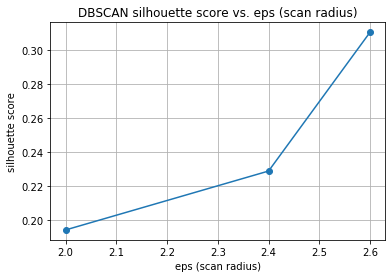

In [46]:
plt.figure()
plt.plot([2, 2.4, 2.6], dbc_silhouette_scores, marker='o')
plt.title('DBSCAN silhouette score vs. eps (scan radius)')
plt.xlabel('eps (scan radius)')
plt.ylabel('silhouette score')
plt.grid()
plt.show()

The general trend is that the silhouette score increases with `eps`, though these results should be taken with a grain of salt since we have only done 3 iterations.

### Word Clouds of DBSCAN Top Clusters

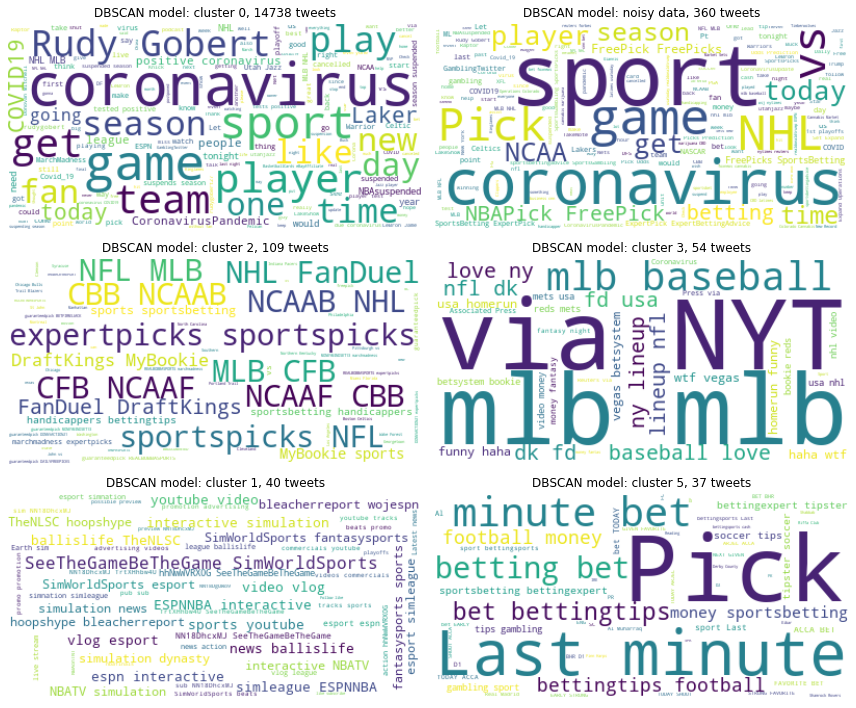

In [47]:
# 6 largest clusters
dbc_top_cluster_nums = dbc_cluster_sizes.index[:6]

plt.subplots(3, 2, figsize=(12, 10))

for i in range(len(dbc_top_cluster_nums)):
    
    # get cluster number
    cluster = dbc_top_cluster_nums[i]

    # generate single string of all tweets in cluster
    df['dbc_cluster'] = dbc.labels_
    cluster_tweets = df['tweet'][df['dbc_cluster'] == cluster]
    cluster_tweets_str = ' '.join(tweet for tweet in cluster_tweets)

    # create word cloud
    wordcloud = WordCloud(
        stopwords = stopwords + ['https', 'co', 'nbatwitter'],
        background_color = 'white',
        random_state = 1
    ).generate(cluster_tweets_str)

    plt.subplot(3, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    if cluster == -1:
        plt.title(f'DBSCAN model: noisy data, {dbc_cluster_sizes[cluster]} tweets')
    else:
        plt.title(f'DBSCAN model: cluster {cluster}, {dbc_cluster_sizes[cluster]} tweets')
    plt.axis('off')

plt.tight_layout()
plt.show()

---

# **Conclusion**

All of the models we built have done a decent job of identifying desirable and undesirable clusters in the tweets corpus:

- The topics in the **16-topic LDA model** were discernable and distinct, but no numerical metric was used to evaluate the performance of the model - only the human-intepretability of each topic and the intertopic distance map topic overlap were used
- The **16-means clustering model** found interpretable clusters, but identified all tweets from single accounts as their own clusters.  The performance, gauged by the silhouette score, was poor and indicated topic overlap
- The **DBSCAN model with `eps = 2.6` and `min_samples = 10`** had an improved silhouette score over the 16-means clustering model (indicating that topics were more distinct and exhibited less overlap), but that was because it seemed to lump all worthwhile topics into either a giant cluster or the noisy data, then assign groups of tweets from single accounts to their own much-smaller clusters

I would be led to believe that the "poor performance" in some of these models is actually attributed to the dataset.  Again, we noticed sports betting tweets littered throughout, and also tweets from bots that append the same group of hashtags to the end of every one of their tweets.  It's good to know that the models pick up on these groupings, but future work should include finding a way to remove tweets from bots from the dataset.

Some of the most prevalent topics/clusters across all models are:

- coronavirus
    - Rudy Gobert, Emmanuel Mudiay, and Donovan Mitchell contracting it
    - The NBA subsequently suspending its season
    - Ensuing discussions in other sports leagues about what they should do
- sports betting and daily fantasy sports
    - picks, strategies, advice
- team/player-specific
    - large franchises (Los Angeles Lakers, Golden State Warriors, New York Knicks)
    - most popular players (LeBron James, Stephen Curry)

The coronavirus and franchise/player-specific topics are not that surprising, but I did not know that Twitter was a popular platform for sports betting companies and figures.

## **Next Steps**

- Analyze a larger dataset of tweets
    - NBA games were only played on 2 of the nights that are included in the dataset, so only the teams that played on either of these nights would likely be represented
    - Unfortunately the coronavirus pandemic forced the league to suspend their season, but I would consider attempting this project again with a new dataset that is collected when a future season is in full effect
- Filter out bots
    - Because they tweet so frequently and often append the same hashtags to every tweet, our machine learning models pick up strongly on that, but that's not really something we might want to identify
    - Would we just remove tweets from the suspect users from our dataset?  We have a pretty good understanding of which accounts these are
    - The JSON objects for each tweet returned by the API include a `statuses_count` and `created_at` fields under `user`.  We could probably use these to calculate a tweet rate for accounts, and filter out those who exceed some tweet rate threshold
- Try different `result_type` parameters in the `twitter.api.Api` `.GetSearch()` method (recent, popular, mixed)
    - We could have missed out on popular/influential tweets since we set `result_type = recent`
- Try incorporating different search terms
    - "#NBA" as a search term proved to be decent in returning tweets that are actually about the NBA, however it is likely that not all tweets about the NBA contain that hashtag!
- Topic filtering
    - We saw a lot of content in our dataset about sports betting.  This is not something I personally care about, so I would try to find a way to get rid of any of these tweets.  Maybe include certain content-specific words in the list of stop words?
- Modeling
    - Explore the different parameters in LDA
    - If possible, find ways to evaluate LDA
    - More exploration and evaluation of the DBSCAN parameters
    - Test other models (e.g. expectation-maximization algorithm)